In [ ]:
import tensorflow as tf
import keras

import os

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_loss(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0,1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset was downloaded from Kaggle. No description was given about the dataset. fortunately, another post containing same dataset uploaded to kaggle describes the images found within it as 48x48 pixel grayscale images of faces.

*The link for the kaggle dataset :*
[kaggle link](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset)

In [ ]:
!unzip gdrive/MyDrive/Bootcamp/ds-final-project/faces_expr.zip -d /content/gdrive/MyDrive/Bootcamp/ds-final-project  > /dev/null

Investigate dataset from kaggle. It seems as if there are empty folders within dataset. Will delete.

In [ ]:
FOLDER_PATH = ['angry', 'disgust',	'fear',  'happy',  'neutral',  'sad',  'surprise']

ROOT_PATH = 'gdrive/MyDrive/Bootcamp/ds-final-project'
sub_root = ['images/images/train', 'images/images/validation', 'images/train','images/validation']
to_delete = []

for i in sub_root:
  print('-------',i,'--------')
  num_files_in_dir = 0
  for j in FOLDER_PATH:
    num_files_in_sub_dir = len(os.listdir(os.path.join(ROOT_PATH, i, j)))
    print(j,' ', num_files_in_sub_dir)
    num_files_in_dir += num_files_in_sub_dir
  print('\n-------\n', num_files_in_dir, '\n-------\n')

  if num_files_in_dir  < 1500:
    to_delete.append(i)

------- images/images/train --------
angry   3993
disgust   436
fear   4103
happy   7164
neutral   4982
sad   4938
surprise   3205

-------
 28821 
-------

------- images/images/validation --------
angry   960
disgust   111
fear   1018
happy   1825
neutral   1216
sad   1139
surprise   797

-------
 7066 
-------

------- images/train --------
angry   3993
disgust   436
fear   4103
happy   7164
neutral   4982
sad   4938
surprise   3205

-------
 28821 
-------

------- images/validation --------
angry   960
disgust   111
fear   1018
happy   1825
neutral   1216
sad   1139
surprise   797

-------
 7066 
-------



In [ ]:
#delete all useless folders
import shutil

for filePath in to_delete:
    try:
        shutil.rmtree(os.path.join(ROOT_PATH, filePath))
        # os.remove()
    except:
        print("Error while deleting file : ", filePath)

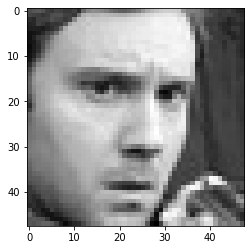

In [ ]:
plt.imshow(plt.imread('/content/gdrive/MyDrive/Bootcamp/ds-final-project/images/images/train/angry/0.jpg'),cmap='gray')

In [ ]:
#batch size
BS = 16
dir_folder = '/content/gdrive/MyDrive/Bootcamp/ds-final-project/images/images/'

#scale the data from 0 to 1 for the model to process
train_generator = ImageDataGenerator(
    rescale = (1/255) 
    # validation_split=0.2,
    # horizontal_flip=True,
    # rotation_range=10,
) 

test_generator = ImageDataGenerator(
    rescale = (1/255)
) 

train = train_generator.flow_from_directory (
    dir_folder+'train', 
    target_size = (48,48),
    batch_size = BS, 
    class_mode = 'categorical',
    shuffle=True
)

valid = train_generator.flow_from_directory (
    dir_folder+'validation', 
    target_size = (48,48),
    batch_size = BS, 
    class_mode = 'categorical',
    shuffle=True
)

# test = test_generator.flow_from_directory (
#     dir_folder+'test', 
#     target_size = (128,128),
#     batch_size = BS, 
#     class_mode = 'categorical',
#     shuffle=False

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [164]:
in_shape = train.target_size + (3,)
num_cat = 7 #classes

shallow_sequence = [
    
    #layer 1
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=in_shape), #stride size = 1
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    #layer 2
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),


    #FC layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),

    #logistic layer
    layers.Dense(num_cat, activation='softmax')

  ]

In [165]:
def facial_expr_seq(sequence):

  model = keras.Sequential(sequence)
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [156]:
check = facial_expr_seq(shallow_sequence)

In [157]:
check.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 44, 44, 64)       

In [158]:
check.fit_generator(
    train,
    steps_per_epoch = train.samples // BS,
    validation_data = valid, 
    validation_steps = valid.samples // BS,
    epochs = 8
)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


1801/1801 [==============================] - 71s 39ms/step - loss: 2.7139 - accuracy: 0.2737 - val_loss: 8.1504 - val_accuracy: 0.2731
Epoch 2/8
1801/1801 [==============================] - 68s 38ms/step - loss: 1.6699 - accuracy: 0.3071 - val_loss: 2.2558 - val_accuracy: 0.3098
Epoch 3/8
1801/1801 [==============================] - 71s 40ms/step - loss: 1.6384 - accuracy: 0.3159 - val_loss: 2.4181 - val_accuracy: 0.3155
Epoch 4/8
1801/1801 [==============================] - 69s 38ms/step - loss: 1.6210 - accuracy: 0.3184 - val_loss: 2.8018 - val_accuracy: 0.3139
Epoch 5/8
1801/1801 [==============================] - 67s 37ms/step - loss: 1.6038 - accuracy: 0.3371 - val_loss: 20.0796 - val_accuracy: 0.2697
Epoch 6/8
1801/1801 [==============================] - 68s 38ms/step - loss: 1.5927 - accuracy: 0.3413 - val_loss: 20.0545 - val_accuracy: 0.2469
Epoch 7/8
1801/1801 [==============================] - 66s 37ms/step - loss: 1.6085 - accuracy: 0.3491 - val_loss: 14.5542 - val_accuracy:

In [ ]:
(plt.imread('/content/gdrive/MyDrive/Bootcamp/ds-final-project/images/images/train/angry/0.jpg')/255).shape

(48, 48)

In [ ]:
import keras.utils as image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(48, 48))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
trial = load_image('/content/gdrive/MyDrive/Bootcamp/ds-final-project/images/images/train/angry/0.jpg')

In [ ]:
np.argmax(check.predict(trial))

1/1 [==============================] - 0s 24ms/step


4

In [166]:
history = facial_expr_seq(shallow_sequence).fit_generator(
    train,
    steps_per_epoch = train.samples // BS,
    validation_data = valid, 
    validation_steps = valid.samples // BS,
    epochs = 6
)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


1801/1801 [==============================] - 70s 38ms/step - loss: 2.1799 - accuracy: 0.3576 - val_loss: 1.8556 - val_accuracy: 0.3600
Epoch 2/6
1801/1801 [==============================] - 66s 37ms/step - loss: 1.4702 - accuracy: 0.4356 - val_loss: 1.6666 - val_accuracy: 0.4076
Epoch 3/6
1801/1801 [==============================] - 65s 36ms/step - loss: 1.3868 - accuracy: 0.4708 - val_loss: 1.4264 - val_accuracy: 0.4454
Epoch 4/6
1801/1801 [==============================] - 65s 36ms/step - loss: 1.2863 - accuracy: 0.5153 - val_loss: 1.7366 - val_accuracy: 0.4158
Epoch 5/6
1801/1801 [==============================] - 65s 36ms/step - loss: 1.1858 - accuracy: 0.5557 - val_loss: 1.4419 - val_accuracy: 0.4728
Epoch 6/6
1801/1801 [==============================] - 65s 36ms/step - loss: 1.0709 - accuracy: 0.6028 - val_loss: 1.4683 - val_accuracy: 0.4711


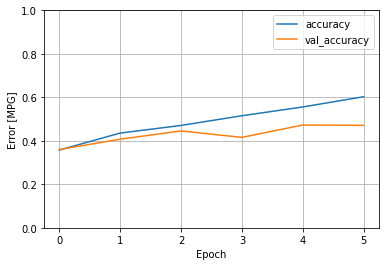

In [167]:
plot_loss(history)